<a href="https://colab.research.google.com/github/Harshit-tech9/Telecom-churn-case-study/blob/main/Telecom_churn_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing all the required Library

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix  
from sklearn.model_selection import train_test_split, cross_val_score
# Import the AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier
#import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTEN 
from sklearn.model_selection import RepeatedStratifiedKFold 
# example of grid searching key hyperparameters for adaboost on a classification dataset
from sklearn.model_selection import GridSearchCV


sns.set_theme(style="whitegrid")
sns.axes_style('white')
sns.set_style('white') 

pd.set_option('display.max_columns', None)

## Reading the CSV.

In [3]:
df = pd.read_csv('test.csv', header = None) 
pattern = r',(?=(?:[^"]*"[^"]*")*[^"]*$)'
df = df[0].str.split(pattern, expand=True) 
headers = df.iloc[0]
new_df  = pd.DataFrame(df.values[1:], columns=headers) 
new_df.head()

0  customerID  gender SeniorCitizen Partner Dependents tenure PhoneService  \
0  0002-ORFBO  Female             0     Yes        Yes      9          Yes   
1  0003-MKNFE    Male             0      No         No      9          Yes   
2  0004-TLHLJ    Male             0      No         No      4          Yes   
3  0011-IGKFF    Male             1     Yes         No     13          Yes   
4  0013-EXCHZ  Female             1     Yes         No      3          Yes   

0 MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL             No          Yes               No   
1           Yes             DSL             No           No               No   
2            No     Fiber optic             No           No              Yes   
3            No     Fiber optic             No          Yes              Yes   
4            No     Fiber optic             No           No               No   

0 TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0         Yes         Yes              No        One year              Yes   
1          No          No             Yes  Month-to-month               No   
2          No          No              No  Month-to-month              Yes   
3          No         Yes             Yes  Month-to-month              Yes   
4         Yes         Yes              No  Month-to-month              Yes   

0     PaymentMethod MonthlyCharges TotalCharges Churn  
0      Mailed check           65.6        593.3    No  
1      Mailed check           59.9        542.4    No  
2  Electronic check           73.9       280.85   Yes  
3  Electronic check             98      1237.85   Yes  
4      Mailed check           83.9        267.4   Yes

## Understanding the Dataframe

In [4]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   object
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   object
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

Here we do not have any null value present in the data. Another thing we observed in dataframe that Total charges column contains a null values as ' ', Therfore removing all the rows with such empty string values.

In [5]:
new_df = new_df[new_df['TotalCharges'] != ' '] 

# Univariate Analysis

In [6]:
new_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object', name=0)

In [7]:
df = new_df[['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'Churn']]

In [8]:
fig, ax = plt.subplots(8,2, figsize = (20, 30), dpi = 300)
ax = ax.flatten() 

for i , column in enumerate(df.columns):
    sns.countplot(x=df[column], ax = ax[i])
 
    
fig.suptitle('Distribution of Features in Data Set', fontsize = 12, fontweight = 'bold')
plt.tight_layout()

1. Male and Female are almost in equal count. 
2. Senior citizen counts are very much less compared to Non-senior citizen. 
3. Yes and No count in partner is almost considerable. 
4. around 60% od people do not have any dependents. 
5. All the customers have a Phone Service there are very few customers without the phone services. 

# Bivariate analysis

In [9]:
fig, ax = plt.subplots(8,2, figsize = (20, 30), dpi = 300)
ax = ax.flatten() 

for i , column in enumerate(df.columns):
    sns.countplot(x=df[column], ax = ax[i], hue=df['Churn'])
 
    
fig.suptitle('Distribution of Features in Data Set', fontsize = 12, fontweight = 'bold')
plt.tight_layout()

#### Changing the datatypes of MonthlyCharges, TotalCharges and tenure

In [10]:
new_df['MonthlyCharges'] = new_df['MonthlyCharges'].apply(lambda x: float(x.split()[0].replace(',', '')))
new_df['TotalCharges'] = new_df['TotalCharges'].apply(lambda x: float(x.split()[0].replace(',', '')))
new_df['tenure'] = new_df['tenure'].apply(lambda x: float(x.split()[0].replace(',', '')))

In [13]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   float64
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


functions for grouping all columns.

In [14]:
def group_by(column, column1):
  x = pd.DataFrame(new_df.groupby([column, 'Churn'])[column1].sum()).reset_index()
  return x

In [15]:
df1 = group_by('gender', 'MonthlyCharges')
df2 = group_by('SeniorCitizen', 'MonthlyCharges') 
df3 = group_by('Partner', 'MonthlyCharges')                                          
df4 = group_by('Dependents', 'MonthlyCharges')                                             
df5 = group_by('PhoneService', 'MonthlyCharges')                                             
df6 = group_by('MultipleLines', 'MonthlyCharges')                                             
df7 = group_by('InternetService', 'MonthlyCharges')                                             
df8 = group_by('OnlineSecurity', 'MonthlyCharges')   
df9 = group_by('OnlineBackup', 'MonthlyCharges')   
df10 = group_by('DeviceProtection', 'MonthlyCharges')  
df11 = group_by('TechSupport', 'MonthlyCharges')  
df12 = group_by('StreamingTV', 'MonthlyCharges')  
df13 = group_by('StreamingMovies', 'MonthlyCharges')  
df14 = group_by('Contract', 'MonthlyCharges')  
df15 = group_by('PaperlessBilling', 'MonthlyCharges')  
df16 = pd.DataFrame(new_df.groupby(['Churn'])['MonthlyCharges'].sum()).reset_index()

Writing a function to display all the dataframes

In [16]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [17]:
display_side_by_side(df1,df2,df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16)

gender 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 Female 
 No 
 156901.05 
 
 
 1 
 Female 
 Yes 
 70248.55 
 
 
 2 
 Male 
 No 
 159629.10 
 
 
 3 
 Male 
 Yes 
 68882.30 
 
 
 
 
 
 
 SeniorCitizen 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 0 
 No 
 263794.90 
 
 
 1 
 0 
 Yes 
 100711.25 
 
 
 2 
 1 
 No 
 52735.25 
 
 
 3 
 1 
 Yes 
 38419.60 
 
 
 
 
 
 
 Partner 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 No 
 139718.45 
 
 
 1 
 No 
 Yes 
 85741.15 
 
 
 2 
 Yes 
 No 
 176811.70 
 
 
 3 
 Yes 
 Yes 
 53389.70 
 
 
 
 
 
 
 Dependents 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 No 
 215148.35 
 
 
 1 
 No 
 Yes 
 115376.50 
 
 
 2 
 Yes 
 No 
 101381.80 
 
 
 3 
 Yes 
 Yes 
 23754.35 
 
 
 
 
 
 
 PhoneService 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 No 
 22174.15 
 
 
 1 
 No 
 Yes 
 6380.75 
 
 
 2 
 Yes 
 No 
 294356.00 
 
 
 3 
 Yes 
 Yes 
 132750.10 
 
 
 
 
 
 
 MultipleLines 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 No 
 126521.00 
 
 
 1 
 No 
 Yes 
 57039.60 
 
 
 2 
 No phone service 
 No 
 22174.15 
 
 
 3 
 No phone service 
 Yes 
 6380.75 
 
 
 4 
 Yes 
 No 
 167835.00 
 
 
 5 
 Yes 
 Yes 
 75710.50 
 
 
 
 
 
 
 InternetService 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 DSL 
 No 
 117811.45 
 
 
 1 
 DSL 
 Yes 
 22529.20 
 
 
 2 
 Fiber optic 
 No 
 168984.35 
 
 
 3 
 Fiber optic 
 Yes 
 114300.05 
 
 
 4 
 No 
 No 
 29734.35 
 
 
 5 
 No 
 Yes 
 2301.60 
 
 
 
 
 
 
 OnlineSecurity 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 No 
 151938.25 
 
 
 1 
 No 
 Yes 
 112762.75 
 
 
 2 
 No internet service 
 No 
 29734.35 
 
 
 3 
 No internet service 
 Yes 
 2301.60 
 
 
 4 
 Yes 
 No 
 134857.55 
 
 
 5 
 Yes 
 Yes 
 24066.50 
 
 
 
 
 
 
 OnlineBackup 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 No 
 130218.15 
 
 
 1 
 No 
 Yes 
 91873.85 
 
 
 2 
 No internet service 
 No 
 29734.35 
 
 
 3 
 No internet service 
 Yes 
 2301.60 
 
 
 4 
 Yes 
 No 
 156577.65 
 
 
 5 
 Yes 
 Yes 
 44955.40 
 
 
 
 
 
 
 DeviceProtection 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 No 
 129696.10 
 
 
 1 
 No 
 Yes 
 88752.25 
 
 
 2 
 No internet service 
 No 
 29734.35 
 
 
 3 
 No internet service 
 Yes 
 2301.60 
 
 
 4 
 Yes 
 No 
 157099.70 
 
 
 5 
 Yes 
 Yes 
 48077.00 
 
 
 
 
 
 
 TechSupport 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 No 
 148248.90 
 
 
 1 
 No 
 Yes 
 110709.80 
 
 
 2 
 No internet service 
 No 
 29734.35 
 
 
 3 
 No internet service 
 Yes 
 2301.60 
 
 
 4 
 Yes 
 No 
 138546.90 
 
 
 5 
 Yes 
 Yes 
 26119.45 
 
 
 
 
 
 
 StreamingTV 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 No 
 120513.10 
 
 
 1 
 No 
 Yes 
 63164.40 
 
 
 2 
 No internet service 
 No 
 29734.35 
 
 
 3 
 No internet service 
 Yes 
 2301.60 
 
 
 4 
 Yes 
 No 
 166282.70 
 
 
 5 
 Yes 
 Yes 
 73664.85 
 
 
 
 
 
 
 StreamingMovies 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 No 
 118726.70 
 
 
 1 
 No 
 Yes 
 63263.55 
 
 
 2 
 No internet service 
 No 
 29734.35 
 
 
 3 
 No internet service 
 Yes 
 2301.60 
 
 
 4 
 Yes 
 No 
 168069.10 
 
 
 5 
 Yes 
 Yes 
 73565.70 
 
 
 
 
 
 
 Contract 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 Month-to-month 
 No 
 136447.05 
 
 
 1 
 Month-to-month 
 Yes 
 120847.10 
 
 
 2 
 One year 
 No 
 81678.45 
 
 
 3 
 One year 
 Yes 
 14118.45 
 
 
 4 
 Two year 
 No 
 98404.65 
 
 
 5 
 Two year 
 Yes 
 4165.30 
 
 
 
 
 
 
 PaperlessBilling 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 No 
 119381.50 
 
 
 1 
 No 
 Yes 
 29620.85 
 
 
 2 
 Yes 
 No 
 197148.65 
 
 
 3 
 Yes 
 Yes 
 109510.00 
 
 
 
 
 
 
 Churn 
 MonthlyCharges 
 
 
 
 
 0 
 No 
 316530.15 
 
 
 1 
 Yes 
 139130.85

In [18]:
def bar_plot(data, column1, ax, column2 = 'MonthlyCharges', column3='Churn'):
  figure = sns.barplot(data= data, x=column1, y=column2, hue=column3, ax=ax)
  return figure 

In [19]:
fig, ax = plt.subplots(8,2, figsize = (20, 30), dpi = 300)
bar_plot(df1, "gender", ax[0,0])
bar_plot(df2, "SeniorCitizen", ax=ax[0,1])
bar_plot(df3, "Partner", ax=ax[1,0])
bar_plot(df4, "Dependents", ax=ax[1,1])
bar_plot(df5, "PhoneService", ax=ax[2,0])
bar_plot(df6, "MultipleLines", ax=ax[2,1])
bar_plot(df7, "InternetService", ax=ax[3,0])
bar_plot(df8, "OnlineSecurity", ax=ax[3,1])
bar_plot(df9, "OnlineBackup", ax=ax[4,0])
bar_plot(df10, "DeviceProtection", ax=ax[4,1])
bar_plot(df11, "TechSupport", ax=ax[5,0])
bar_plot(df12, "StreamingTV", ax=ax[5,1])
bar_plot(df13, "StreamingMovies", ax=ax[6,0])
bar_plot(df14, "Contract", ax=ax[6,1])
bar_plot(df15, "PaperlessBilling", ax=ax[7,0])
bar_plot(df16, "Churn", ax=ax[7,1])
plt.tight_layout()
plt.show()

In [20]:
df1 = group_by('gender', 'TotalCharges')
df2 = group_by('SeniorCitizen', 'TotalCharges') 
df3 = group_by('Partner', 'TotalCharges')                                          
df4 = group_by('Dependents', 'TotalCharges')                                             
df5 = group_by('PhoneService', 'TotalCharges')                                             
df6 = group_by('MultipleLines', 'TotalCharges')                                             
df7 = group_by('InternetService', 'TotalCharges')                                             
df8 = group_by('OnlineSecurity', 'TotalCharges')   
df9 = group_by('OnlineBackup', 'TotalCharges')   
df10 = group_by('DeviceProtection', 'TotalCharges')  
df11 = group_by('TechSupport', 'TotalCharges')  
df12 = group_by('StreamingTV', 'TotalCharges')  
df13 = group_by('StreamingMovies', 'TotalCharges')  
df14 = group_by('Contract', 'TotalCharges')  
df15 = group_by('PaperlessBilling', 'TotalCharges')  
df16 = pd.DataFrame(new_df.groupby(['Churn'])['TotalCharges'].sum()).reset_index()
display_side_by_side(df1,df2,df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16)

gender 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 Female 
 No 
 6599274.45 
 
 
 1 
 Female 
 Yes 
 1353079.75 
 
 
 2 
 Male 
 No 
 6593967.35 
 
 
 3 
 Male 
 Yes 
 1509847.15 
 
 
 
 
 
 
 SeniorCitizen 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 0 
 No 
 10866095.70 
 
 
 1 
 0 
 Yes 
 1980521.75 
 
 
 2 
 1 
 No 
 2327146.10 
 
 
 3 
 1 
 Yes 
 882405.15 
 
 
 
 
 
 
 Partner 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 No 
 4460894.65 
 
 
 1 
 No 
 Yes 
 1306776.35 
 
 
 2 
 Yes 
 No 
 8732347.15 
 
 
 3 
 Yes 
 Yes 
 1556150.55 
 
 
 
 
 
 
 Dependents 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 No 
 8530129.80 
 
 
 1 
 No 
 Yes 
 2261839.95 
 
 
 2 
 Yes 
 No 
 4663112.00 
 
 
 3 
 Yes 
 Yes 
 601086.95 
 
 
 
 
 
 
 PhoneService 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 No 
 903490.00 
 
 
 1 
 No 
 Yes 
 116804.95 
 
 
 2 
 Yes 
 No 
 12289751.80 
 
 
 3 
 Yes 
 Yes 
 2746121.95 
 
 
 
 
 
 
 MultipleLines 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 No 
 3889934.95 
 
 
 1 
 No 
 Yes 
 679249.95 
 
 
 2 
 No phone service 
 No 
 903490.00 
 
 
 3 
 No phone service 
 Yes 
 116804.95 
 
 
 4 
 Yes 
 No 
 8399816.85 
 
 
 5 
 Yes 
 Yes 
 2066872.00 
 
 
 
 
 
 
 InternetService 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 DSL 
 No 
 4761394.35 
 
 
 1 
 DSL 
 Yes 
 360016.50 
 
 
 2 
 Fiber optic 
 No 
 7440365.50 
 
 
 3 
 Fiber optic 
 Yes 
 2483257.45 
 
 
 4 
 No 
 No 
 991481.95 
 
 
 5 
 No 
 Yes 
 19652.95 
 
 
 
 
 
 
 OnlineSecurity 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 No 
 5391958.80 
 
 
 1 
 No 
 Yes 
 2078605.15 
 
 
 2 
 No internet service 
 No 
 991481.95 
 
 
 3 
 No internet service 
 Yes 
 19652.95 
 
 
 4 
 Yes 
 No 
 6809801.05 
 
 
 5 
 Yes 
 Yes 
 764668.80 
 
 
 
 
 
 
 OnlineBackup 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 No 
 4236523.05 
 
 
 1 
 No 
 Yes 
 1406970.95 
 
 
 2 
 No internet service 
 No 
 991481.95 
 
 
 3 
 No internet service 
 Yes 
 19652.95 
 
 
 4 
 Yes 
 No 
 7965236.80 
 
 
 5 
 Yes 
 Yes 
 1436303.00 
 
 
 
 
 
 
 DeviceProtection 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 No 
 4181294.10 
 
 
 1 
 No 
 Yes 
 1384069.80 
 
 
 2 
 No internet service 
 No 
 991481.95 
 
 
 3 
 No internet service 
 Yes 
 19652.95 
 
 
 4 
 Yes 
 No 
 8020465.75 
 
 
 5 
 Yes 
 Yes 
 1459204.15 
 
 
 
 
 
 
 TechSupport 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 No 
 5232307.20 
 
 
 1 
 No 
 Yes 
 2023779.35 
 
 
 2 
 No internet service 
 No 
 991481.95 
 
 
 3 
 No internet service 
 Yes 
 19652.95 
 
 
 4 
 Yes 
 No 
 6969452.65 
 
 
 5 
 Yes 
 Yes 
 819494.60 
 
 
 
 
 
 
 StreamingTV 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 No 
 4030172.65 
 
 
 1 
 No 
 Yes 
 844587.85 
 
 
 2 
 No internet service 
 No 
 991481.95 
 
 
 3 
 No internet service 
 Yes 
 19652.95 
 
 
 4 
 Yes 
 No 
 8171587.20 
 
 
 5 
 Yes 
 Yes 
 1998686.10 
 
 
 
 
 
 
 StreamingMovies 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 No 
 3931965.80 
 
 
 1 
 No 
 Yes 
 838928.60 
 
 
 2 
 No internet service 
 No 
 991481.95 
 
 
 3 
 No internet service 
 Yes 
 19652.95 
 
 
 4 
 Yes 
 No 
 8269794.05 
 
 
 5 
 Yes 
 Yes 
 2004345.35 
 
 
 
 
 
 
 Contract 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 Month-to-month 
 No 
 3378679.25 
 
 
 1 
 Month-to-month 
 Yes 
 1927182.25 
 
 
 2 
 One year 
 No 
 3792062.30 
 
 
 3 
 One year 
 Yes 
 674991.20 
 
 
 4 
 Two year 
 No 
 6022500.25 
 
 
 5 
 Two year 
 Yes 
 260753.45 
 
 
 
 
 
 
 PaperlessBilling 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 No 
 4742025.45 
 
 
 1 
 No 
 Yes 
 561353.60 
 
 
 2 
 Yes 
 No 
 8451216.35 
 
 
 3 
 Yes 
 Yes 
 2301573.30 
 
 
 
 
 
 
 Churn 
 TotalCharges 
 
 
 
 
 0 
 No 
 13193241.8 
 
 
 1 
 Yes 
 2862926.9

In [21]:
def bar_plot_tc(data, column1, ax, column2 = 'TotalCharges', column3='Churn'):
  figure = sns.barplot(data= data, x=column1, y=column2, hue=column3, ax=ax)
  return figure 

In [22]:
fig, ax = plt.subplots(8,2, figsize = (20, 30), dpi = 300)
bar_plot_tc(df1, "gender", ax[0,0])
bar_plot_tc(df2, "SeniorCitizen", ax=ax[0,1])
bar_plot_tc(df3, "Partner", ax=ax[1,0])
bar_plot_tc(df4, "Dependents", ax=ax[1,1])
bar_plot_tc(df5, "PhoneService", ax=ax[2,0])
bar_plot_tc(df6, "MultipleLines", ax=ax[2,1])
bar_plot_tc(df7, "InternetService", ax=ax[3,0])
bar_plot_tc(df8, "OnlineSecurity", ax=ax[3,1])
bar_plot_tc(df9, "OnlineBackup", ax=ax[4,0])
bar_plot_tc(df10, "DeviceProtection", ax=ax[4,1])
bar_plot_tc(df11, "TechSupport", ax=ax[5,0])
bar_plot_tc(df12, "StreamingTV", ax=ax[5,1])
bar_plot_tc(df13, "StreamingMovies", ax=ax[6,0])
bar_plot_tc(df14, "Contract", ax=ax[6,1])
bar_plot_tc(df15, "PaperlessBilling", ax=ax[7,0])
bar_plot_tc(df16, "Churn", ax=ax[7,1])
plt.tight_layout()
plt.show()

In [23]:
def box_plot(column, ax, data=new_df, x='Churn'):
  fig = sns.boxplot(data=data, y=column, ax = ax, x=x) 
  return fig

# sns.boxplot(data=new_df, y='MonthlyCharges', x='Churn')

Plotting a Box plot

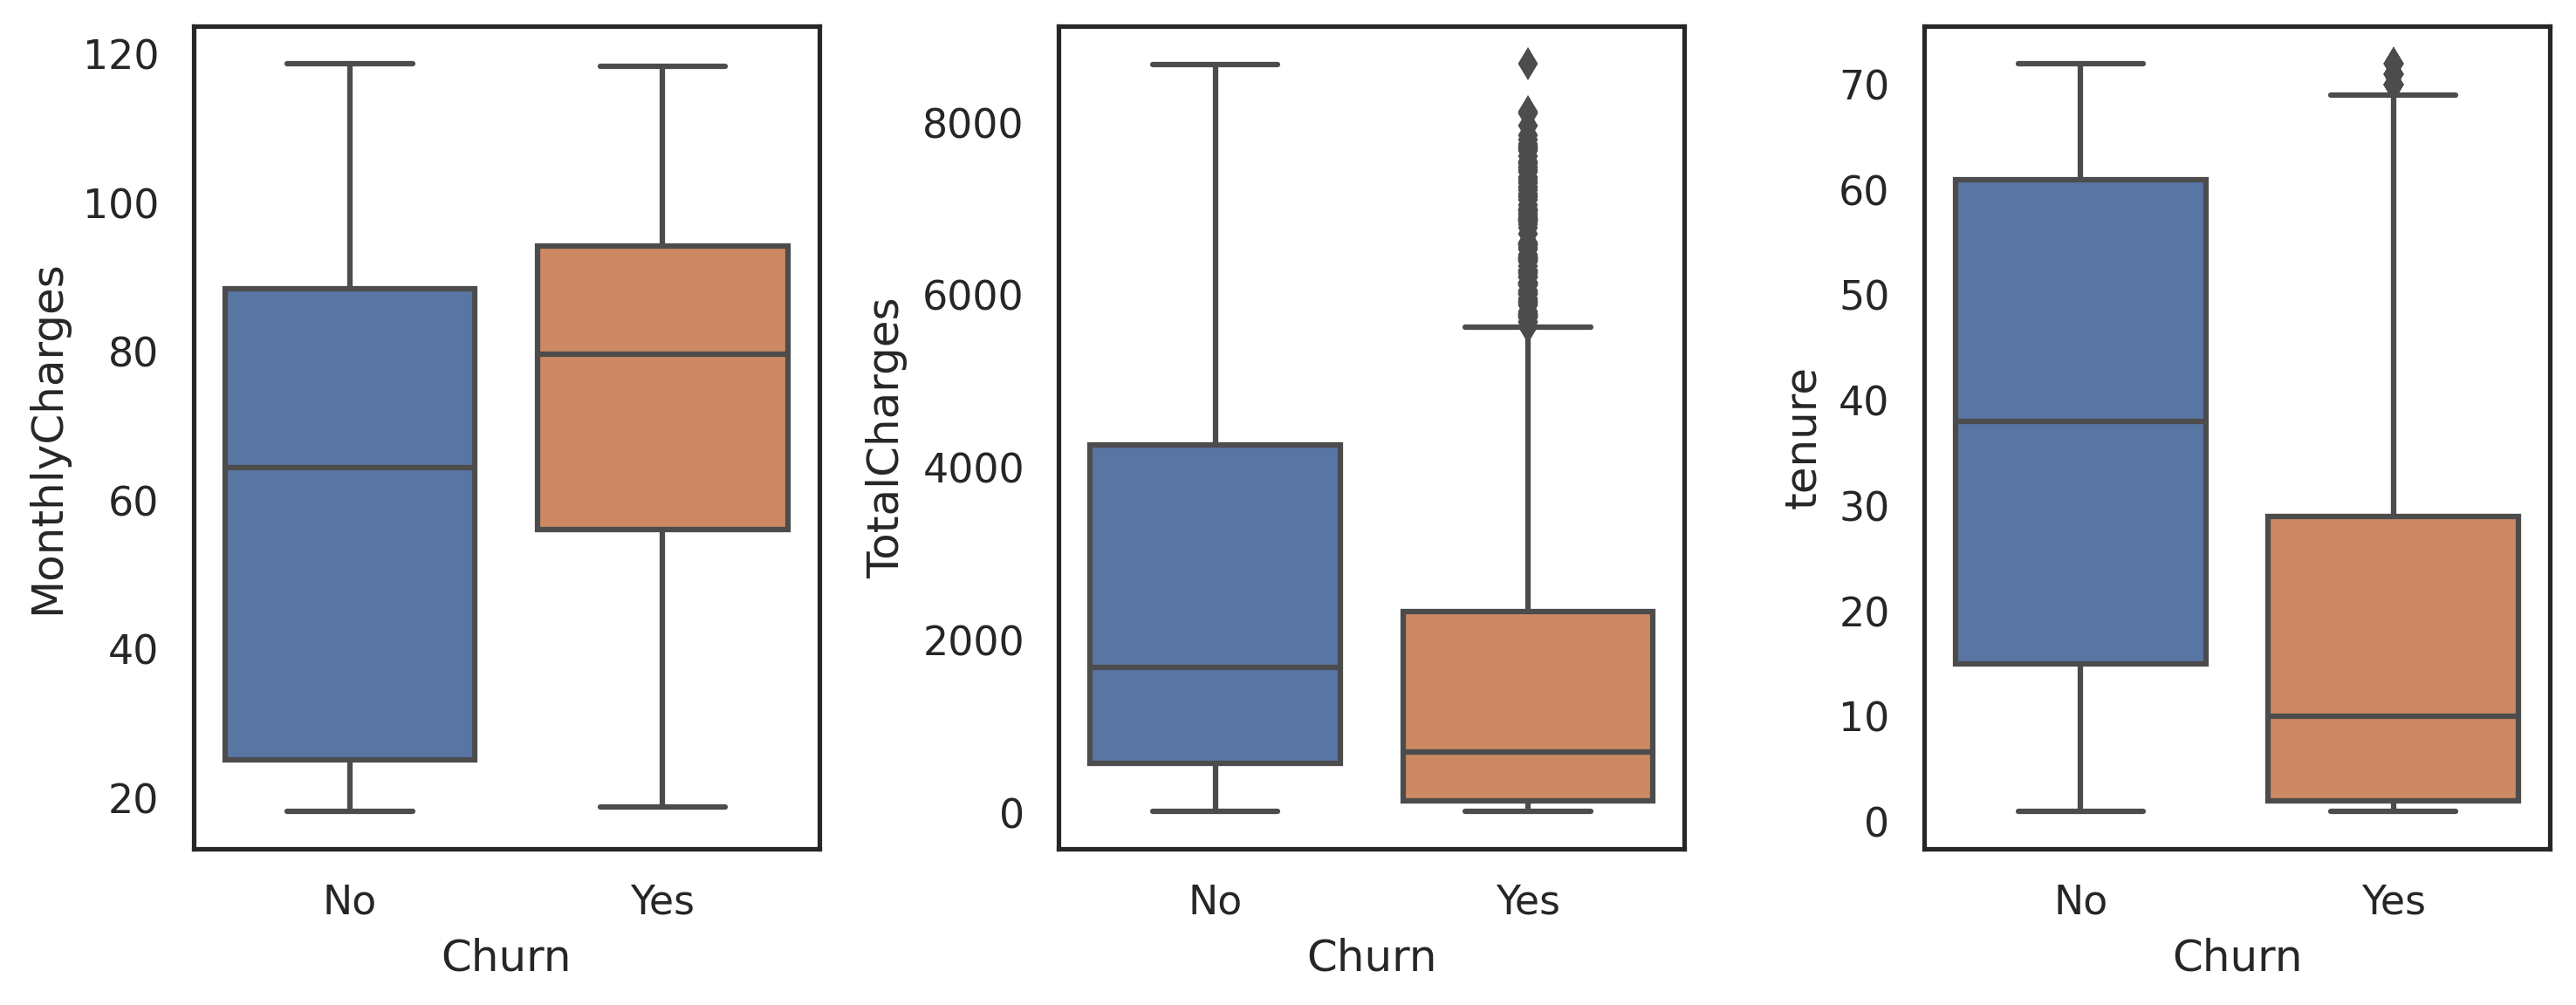

In [24]:
fig, ax = plt.subplots(1,3, figsize = (10,4), dpi = 300)
box_plot("MonthlyCharges", ax[0])
box_plot("TotalCharges", ax=ax[1])
box_plot("tenure", ax=ax[2])
plt.tight_layout()
plt.show()

In [25]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   float64
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


##Mapping all categorical columns

In [26]:
# mapping columns
x = new_df.stack()
x[:] = x.factorize()[0]
map_df = new_df.join(x.unstack().add_suffix('_cat'))

In [27]:
map_df

0     customerID  gender SeniorCitizen Partner Dependents  tenure  \
0     0002-ORFBO  Female             0     Yes        Yes     9.0   
1     0003-MKNFE    Male             0      No         No     9.0   
2     0004-TLHLJ    Male             0      No         No     4.0   
3     0011-IGKFF    Male             1     Yes         No    13.0   
4     0013-EXCHZ  Female             1     Yes         No     3.0   
...          ...     ...           ...     ...        ...     ...   
7038  9987-LUTYD  Female             0      No         No    13.0   
7039  9992-RRAMN    Male             0     Yes         No    22.0   
7040  9992-UJOEL    Male             0      No         No     2.0   
7041  9993-LHIEB    Male             0     Yes        Yes    67.0   
7042  9995-HOTOH    Male             0     Yes        Yes    63.0   

0    PhoneService     MultipleLines InternetService OnlineSecurity  \
0             Yes                No             DSL             No   
1             Yes               Yes             DSL             No   
2             Yes                No     Fiber optic             No   
3             Yes                No     Fiber optic             No   
4             Yes                No     Fiber optic             No   
...           ...               ...             ...            ...   
7038          Yes                No             DSL            Yes   
7039          Yes               Yes     Fiber optic             No   
7040          Yes                No             DSL             No   
7041          Yes                No             DSL            Yes   
7042           No  No phone service             DSL            Yes   

0    OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0             Yes               No         Yes         Yes              No   
1              No               No          No          No             Yes   
2              No              Yes          No          No              No   
3             Yes              Yes          No         Yes             Yes   
4              No               No         Yes         Yes              No   
...           ...              ...         ...         ...             ...   
7038           No               No         Yes          No              No   
7039           No               No          No          No             Yes   
7040          Yes               No          No          No              No   
7041           No              Yes         Yes          No             Yes   
7042          Yes              Yes          No         Yes             Yes   

0           Contract PaperlessBilling     PaymentMethod  MonthlyCharges  \
0           One year              Yes      Mailed check           65.60   
1     Month-to-month               No      Mailed check           59.90   
2     Month-to-month              Yes  Electronic check           73.90   
3     Month-to-month              Yes  Electronic check           98.00   
4     Month-to-month              Yes      Mailed check           83.90   
...              ...              ...               ...             ...   
7038        One year               No      Mailed check           55.15   
7039  Month-to-month              Yes  Electronic check           85.10   
7040  Month-to-month              Yes      Mailed check           50.30   
7041        Two year               No      Mailed check           67.85   
7042        Two year               No  Electronic check           59.00   

0     TotalCharges Churn customerID_cat gender_cat SeniorCitizen_cat  \
0           593.30    No              0          1                 2   
1           542.40    No             11         12                 2   
2           280.85   Yes             16         12                 2   
3          1237.85   Yes             22         12                23   
4           267.40   Yes             27          1                23   
...            ...   ...            ...        ...          

In [28]:
map_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'customerID_cat', 'gender_cat', 'SeniorCitizen_cat', 'Partner_cat',
       'Dependents_cat', 'tenure_cat', 'PhoneService_cat', 'MultipleLines_cat',
       'InternetService_cat', 'OnlineSecurity_cat', 'OnlineBackup_cat',
       'DeviceProtection_cat', 'TechSupport_cat', 'StreamingTV_cat',
       'StreamingMovies_cat', 'Contract_cat', 'PaperlessBilling_cat',
       'PaymentMethod_cat', 'MonthlyCharges_cat', 'TotalCharges_cat',
       'Churn_cat'],
      dtype='object', name=0)

In [29]:
new_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object', name=0)

In [30]:
df_ = new_df[['tenure', 'MonthlyCharges', 'TotalCharges']]

In [31]:
map_df = map_df[['gender_cat', 'SeniorCitizen_cat', 'Partner_cat', 'Dependents_cat','PhoneService_cat', 'MultipleLines_cat', 'InternetService_cat', 'OnlineSecurity_cat', 'OnlineBackup_cat',
                'DeviceProtection_cat', 'TechSupport_cat', 'StreamingTV_cat', 'StreamingMovies_cat', 'Contract_cat', 'PaperlessBilling_cat', 'PaymentMethod_cat', 'Churn_cat']]

In [32]:
map_df

0    gender_cat SeniorCitizen_cat Partner_cat Dependents_cat PhoneService_cat  \
0             1                 2           3              3                3   
1            12                 2           5              5                3   
2            12                 2           5              5                3   
3            12                23           3              5                3   
4             1                23           3              5                3   
...         ...               ...         ...            ...              ...   
7038          1                 2           5              5                3   
7039         12                 2           3              5                3   
7040         12                 2           5              5                3   
7041         12                 2           3              3                3   
7042         12                 2           3              3                5   

0    MultipleLines_cat InternetService_cat OnlineSecurity_cat  \
0                    5                   6                  5   
1                    3                   6                  5   
2                    5                  18                  5   
3                    5                  18                  5   
4                    5                  18                  5   
...                ...                 ...                ...   
7038                 5                   6                  3   
7039                 3                  18                  5   
7040                 5                   6                  5   
7041                 5                   6                  3   
7042                55                   6                  3   

0    OnlineBackup_cat DeviceProtection_cat TechSupport_cat StreamingTV_cat  \
0                   3                    5               3               3   
1                   5                    5               5               5   
2                   5                    3               5               5   
3                   3                    3               5               3   
4                   5                    5               3               3   
...               ...                  ...             ...             ...   
7038                5                    5               3               5   
7039                5                    5               5               5   
7040                3                    5               5               5   
7041                5                    3               3               5   
7042                3                    3               5               3   

0    StreamingMovies_cat Contract_cat PaperlessBilling_cat PaymentMethod_cat  \
0                      5            7                    3                 8   
1                      3           13                    5                 8   
2                      5           13                    3                19   
3                      3           13                    3                19   
4                      5           13                    3                 8   
...                  ...          ...                  ...               ...   
7038                   5            7                    5                 8   
7039                   3           13                    3                19   
7040                   5           13                    3                 8   
7041                   3           37                    5                 8   
7042                   3           37                    5                19   

0    Churn_cat  
0            5  
1            5  
2            3  
3            3  
4            3  
...        ...  
7038         5  
7039         3  
7040         5  
7041         5  
7042         5  

[7032 rows x 17 columns]

In [33]:
final_df = pd.concat([map_df, df_], axis=1)

In [34]:
final_df.head()

0 gender_cat SeniorCitizen_cat Partner_cat Dependents_cat PhoneService_cat  \
0          1                 2           3              3                3   
1         12                 2           5              5                3   
2         12                 2           5              5                3   
3         12                23           3              5                3   
4          1                23           3              5                3   

0 MultipleLines_cat InternetService_cat OnlineSecurity_cat OnlineBackup_cat  \
0                 5                   6                  5                3   
1                 3                   6                  5                5   
2                 5                  18                  5                5   
3                 5                  18                  5                3   
4                 5                  18                  5                5   

0 DeviceProtection_cat TechSupport_cat StreamingTV_cat StreamingMovies_cat  \
0                    5               3               3                   5   
1                    5               5               5                   3   
2                    3               5               5                   5   
3                    3               5               3                   3   
4                    5               3               3                   5   

0 Contract_cat PaperlessBilling_cat PaymentMethod_cat Churn_cat  tenure  \
0            7                    3                 8         5     9.0   
1           13                    5                 8         5     9.0   
2           13                    3                19         3     4.0   
3           13                    3                19         3    13.0   
4           13                    3                 8         3     3.0   

0  MonthlyCharges  TotalCharges  
0            65.6        593.30  
1            59.9        542.40  
2            73.9        280.85  
3            98.0       1237.85  
4            83.9        267.40

In [35]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender_cat            7032 non-null   object 
 1   SeniorCitizen_cat     7032 non-null   object 
 2   Partner_cat           7032 non-null   object 
 3   Dependents_cat        7032 non-null   object 
 4   PhoneService_cat      7032 non-null   object 
 5   MultipleLines_cat     7032 non-null   object 
 6   InternetService_cat   7032 non-null   object 
 7   OnlineSecurity_cat    7032 non-null   object 
 8   OnlineBackup_cat      7032 non-null   object 
 9   DeviceProtection_cat  7032 non-null   object 
 10  TechSupport_cat       7032 non-null   object 
 11  StreamingTV_cat       7032 non-null   object 
 12  StreamingMovies_cat   7032 non-null   object 
 13  Contract_cat          7032 non-null   object 
 14  PaperlessBilling_cat  7032 non-null   object 
 15  PaymentMethod_cat    

In [36]:
final_df = final_df.astype('float64')

<Axes: xlabel='0', ylabel='0'>

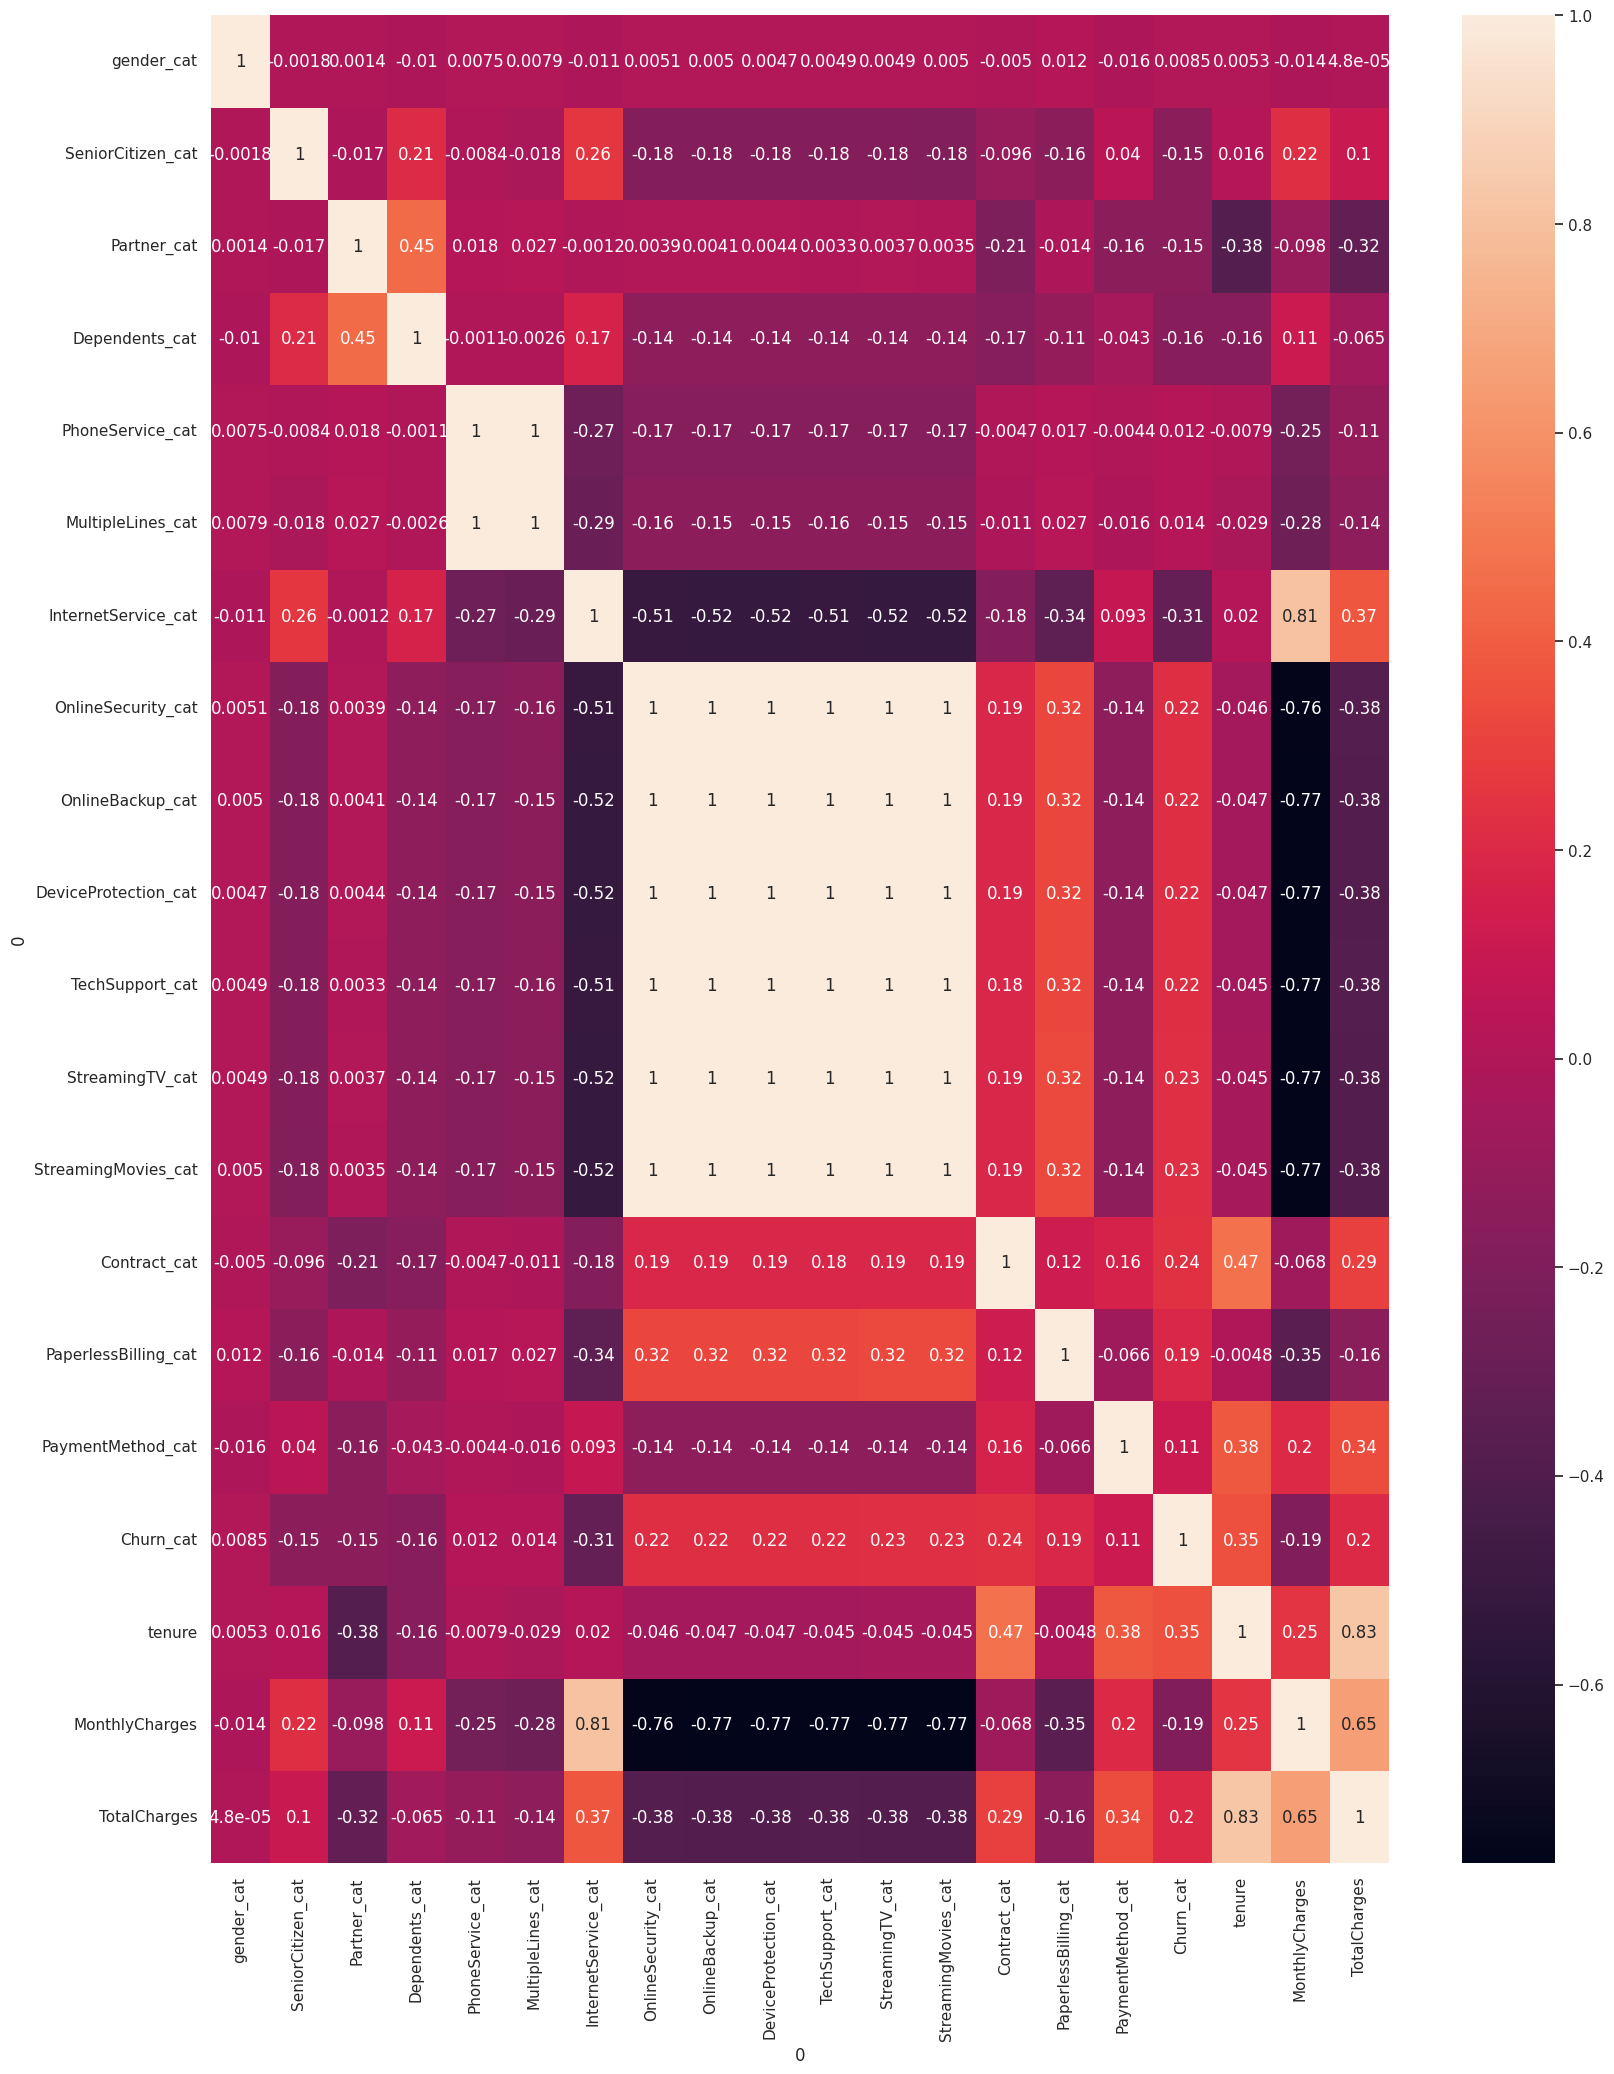

In [37]:
plt.figure(figsize=(19, 24))
sns.heatmap(final_df.corr(), annot=True)

Here we can observe that PhoneService, MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV and Streaming Movies are strongly coorelated to each other therefore we can drop all the columns leaving one.

In [38]:
final_df.columns

Index(['gender_cat', 'SeniorCitizen_cat', 'Partner_cat', 'Dependents_cat',
       'PhoneService_cat', 'MultipleLines_cat', 'InternetService_cat',
       'OnlineSecurity_cat', 'OnlineBackup_cat', 'DeviceProtection_cat',
       'TechSupport_cat', 'StreamingTV_cat', 'StreamingMovies_cat',
       'Contract_cat', 'PaperlessBilling_cat', 'PaymentMethod_cat',
       'Churn_cat', 'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype='object', name=0)

In [39]:
final_df = final_df[['gender_cat', 'SeniorCitizen_cat', 'Partner_cat', 'Dependents_cat', 'MultipleLines_cat', 'InternetService_cat',
                     'OnlineSecurity_cat', 'Contract_cat', 'PaperlessBilling_cat', 'PaymentMethod_cat', 'Churn_cat', 'tenure', 'MonthlyCharges', 'TotalCharges']]

In [40]:
final_df

0     gender_cat  SeniorCitizen_cat  Partner_cat  Dependents_cat  \
0            1.0                2.0          3.0             3.0   
1           12.0                2.0          5.0             5.0   
2           12.0                2.0          5.0             5.0   
3           12.0               23.0          3.0             5.0   
4            1.0               23.0          3.0             5.0   
...          ...                ...          ...             ...   
7038         1.0                2.0          5.0             5.0   
7039        12.0                2.0          3.0             5.0   
7040        12.0                2.0          5.0             5.0   
7041        12.0                2.0          3.0             3.0   
7042        12.0                2.0          3.0             3.0   

0     MultipleLines_cat  InternetService_cat  OnlineSecurity_cat  \
0                   5.0                  6.0                 5.0   
1                   3.0                  6.0                 5.0   
2                   5.0                 18.0                 5.0   
3                   5.0                 18.0                 5.0   
4                   5.0                 18.0                 5.0   
...                 ...                  ...                 ...   
7038                5.0                  6.0                 3.0   
7039                3.0                 18.0                 5.0   
7040                5.0                  6.0                 5.0   
7041                5.0                  6.0                 3.0   
7042               55.0                  6.0                 3.0   

0     Contract_cat  PaperlessBilling_cat  PaymentMethod_cat  Churn_cat  \
0              7.0                   3.0                8.0        5.0   
1             13.0                   5.0                8.0        5.0   
2             13.0                   3.0               19.0        3.0   
3             13.0                   3.0               19.0        3.0   
4             13.0                   3.0                8.0        3.0   
...            ...                   ...                ...        ...   
7038           7.0                   5.0                8.0        5.0   
7039          13.0                   3.0               19.0        3.0   
7040          13.0                   3.0                8.0        5.0   
7041          37.0                   5.0                8.0        5.0   
7042          37.0                   5.0               19.0        5.0   

0     tenure  MonthlyCharges  TotalCharges  
0        9.0           65.60        593.30  
1        9.0           59.90        542.40  
2        4.0           73.90        280.85  
3       13.0           98.00       1237.85  
4        3.0           83.90        267.40  
...      ...             ...           ...  
7038    13.0           55.15        742.90  
7039    22.0           85.10       1873.70  
7040     2.0           50.30         92.75  
7041    67.0           67.85       4627.65  
7042    63.0           59.00       3707.60  

[7032 rows x 14 columns]

Normalizing all the values in dataframe

In [41]:
normalized_df=(final_df-final_df.min())/(final_df.max()- final_df.min())

In [42]:
normalized_df

0     gender_cat  SeniorCitizen_cat  Partner_cat  Dependents_cat  \
0            0.0                0.0          0.0             0.0   
1            1.0                0.0          1.0             1.0   
2            1.0                0.0          1.0             1.0   
3            1.0                1.0          0.0             1.0   
4            0.0                1.0          0.0             1.0   
...          ...                ...          ...             ...   
7038         0.0                0.0          1.0             1.0   
7039         1.0                0.0          0.0             1.0   
7040         1.0                0.0          1.0             1.0   
7041         1.0                0.0          0.0             0.0   
7042         1.0                0.0          0.0             0.0   

0     MultipleLines_cat  InternetService_cat  OnlineSecurity_cat  \
0              0.038462             0.076923            0.022727   
1              0.000000             0.076923            0.022727   
2              0.038462             1.000000            0.022727   
3              0.038462             1.000000            0.022727   
4              0.038462             1.000000            0.022727   
...                 ...                  ...                 ...   
7038           0.038462             0.076923            0.000000   
7039           0.000000             1.000000            0.022727   
7040           0.038462             0.076923            0.022727   
7041           0.038462             0.076923            0.000000   
7042           1.000000             0.076923            0.000000   

0     Contract_cat  PaperlessBilling_cat  PaymentMethod_cat  Churn_cat  \
0              0.0                   0.0           0.000000        1.0   
1              0.2                   1.0           0.000000        1.0   
2              0.2                   0.0           0.366667        0.0   
3              0.2                   0.0           0.366667        0.0   
4              0.2                   0.0           0.000000        0.0   
...            ...                   ...                ...        ...   
7038           0.0                   1.0           0.000000        1.0   
7039           0.2                   0.0           0.366667        0.0   
7040           0.2                   0.0           0.000000        1.0   
7041           1.0                   1.0           0.000000        1.0   
7042           1.0                   1.0           0.366667        1.0   

0       tenure  MonthlyCharges  TotalCharges  
0     0.112676        0.471144      0.066294  
1     0.112676        0.414428      0.060420  
2     0.042254        0.553731      0.030239  
3     0.169014        0.793532      0.140670  
4     0.028169        0.653234      0.028687  
...        ...             ...           ...  
7038  0.169014        0.367164      0.083556  
7039  0.295775        0.665174      0.214043  
7040  0.014085        0.318905      0.008533  
7041  0.929577        0.493532      0.531831  
7042  0.873239        0.405473      0.425664  

[7032 rows x 14 columns]

Plotting a heatmap

<Axes: xlabel='0', ylabel='0'>

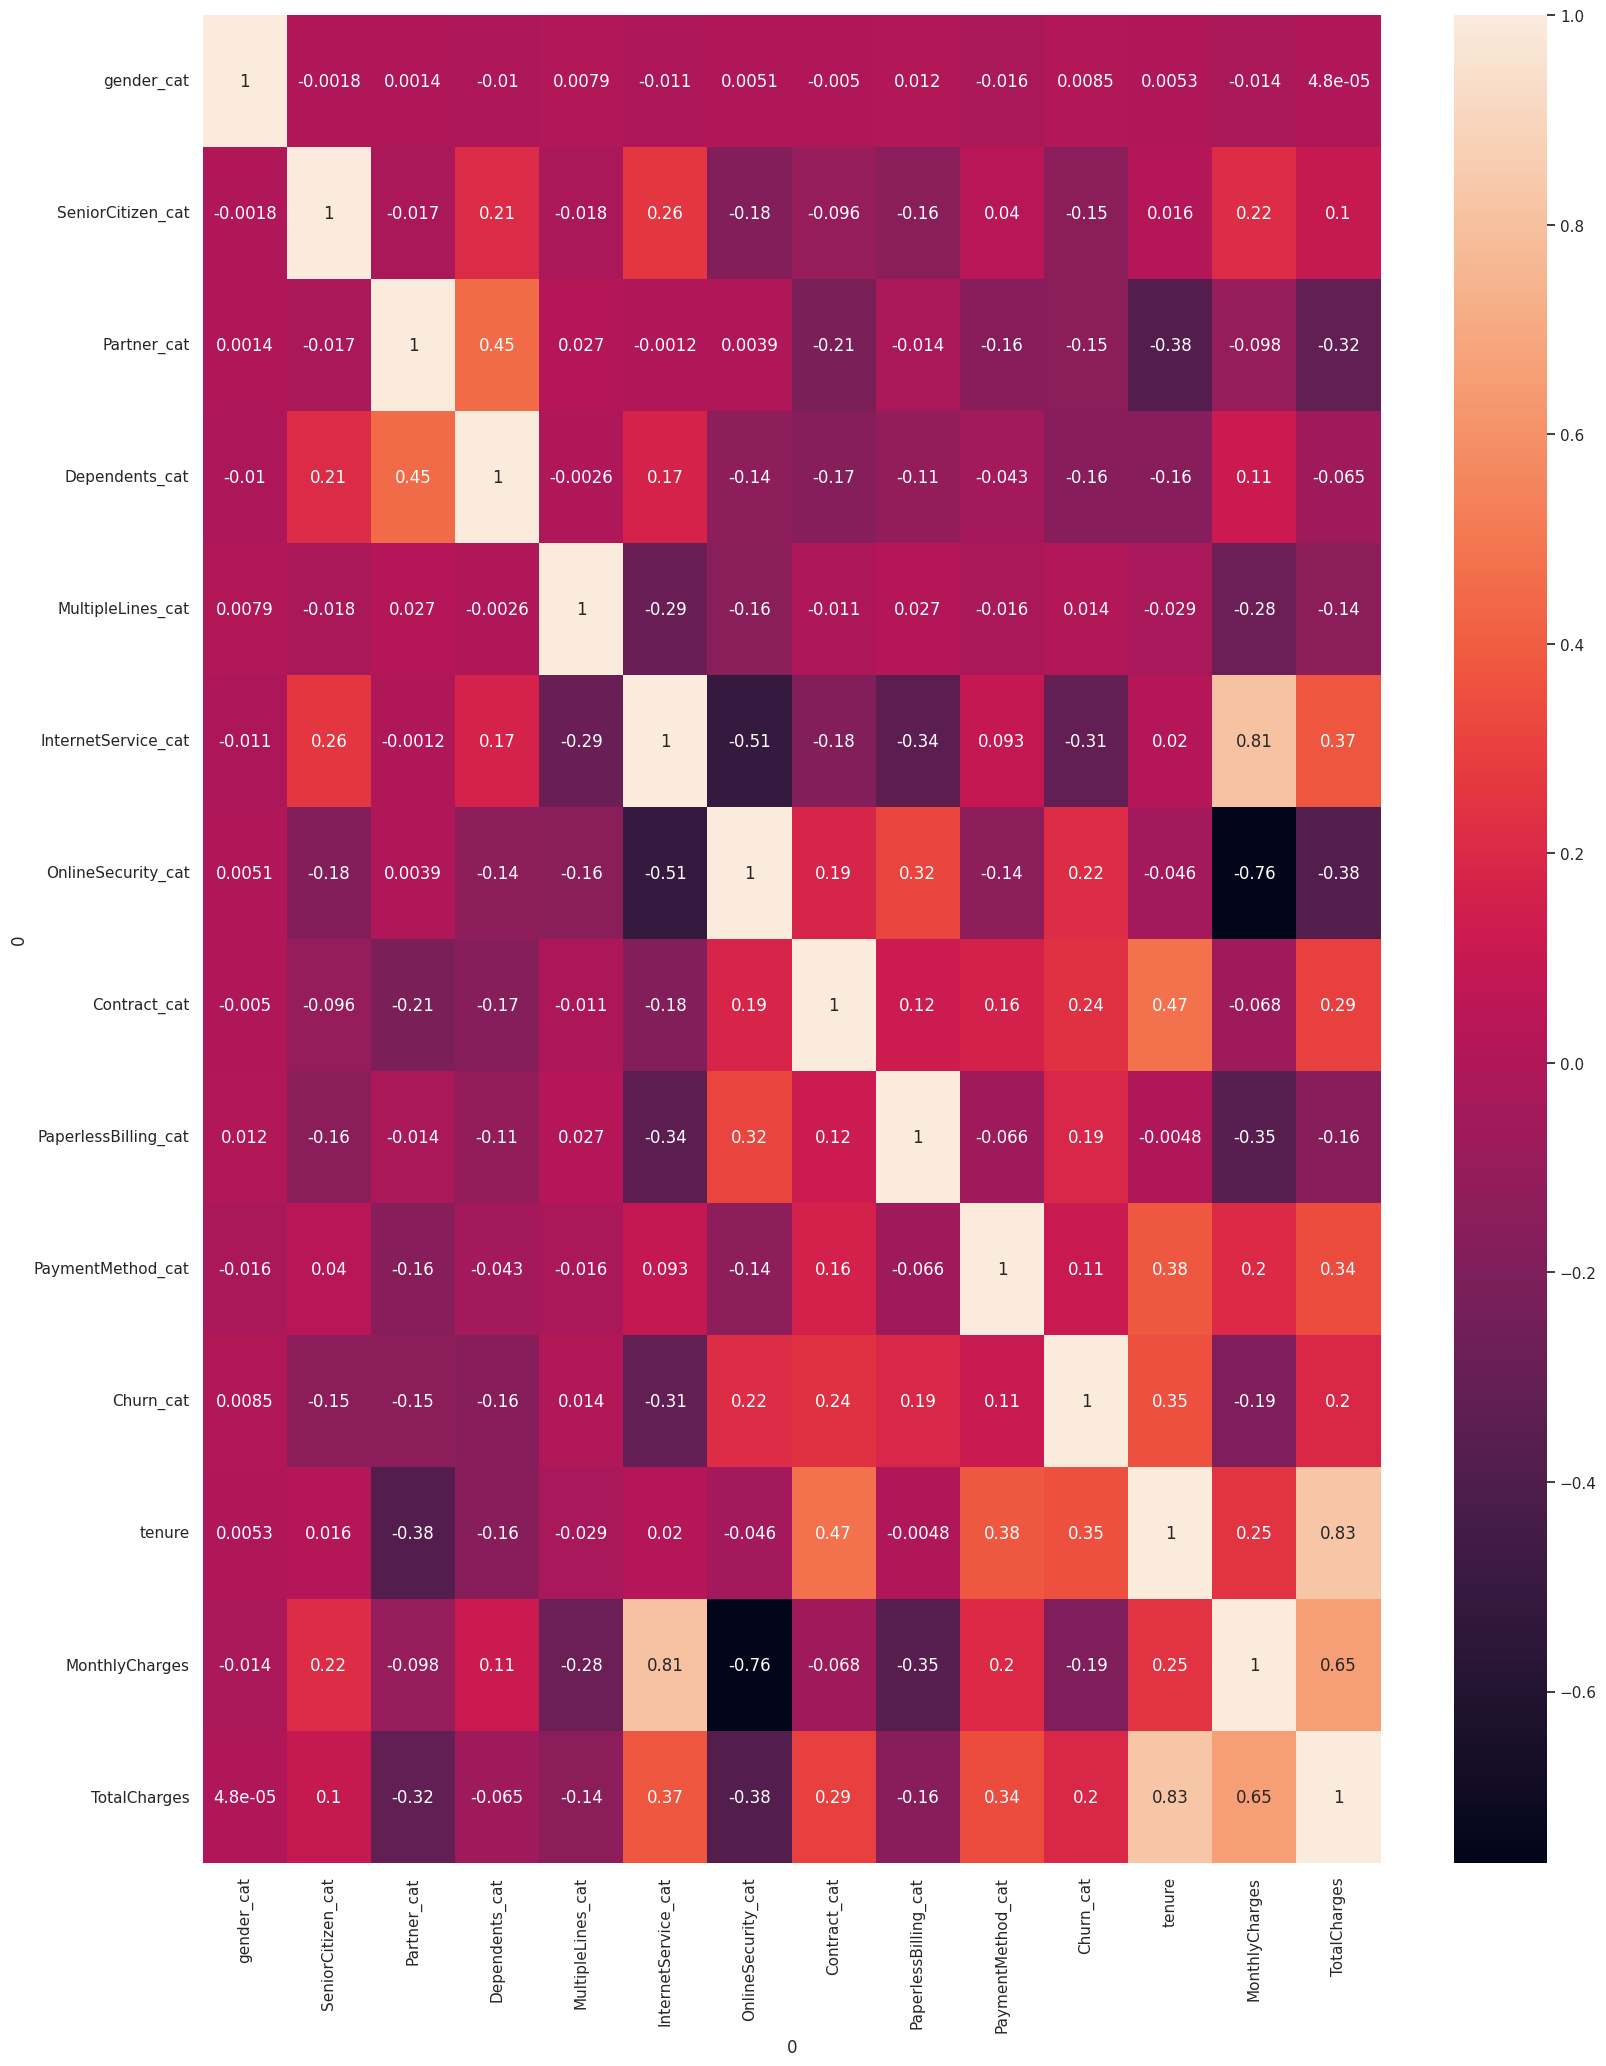

In [43]:
plt.figure(figsize=(19, 24))
sns.heatmap(normalized_df.corr(), annot=True)

# Dropping a columns Churn_cat from X axis and dividing a dataset into train test and split

In [44]:
X = normalized_df.drop(columns=['Churn_cat'])
y = normalized_df[['Churn_cat']]

In [45]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Using Adaboost for Developing Classifier.

In [46]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)

# Train Adaboost Classifer
model1 = abc.fit(X_train, y_train.values.ravel())

#Predict the response for test dataset
y_pred = model1.predict(X_test)

In [47]:
# calculate and print model accuracy
print("AdaBoost Classifier Model Accuracy:", accuracy_score(y_test, y_pred))

AdaBoost Classifier Model Accuracy: 0.7966824644549763


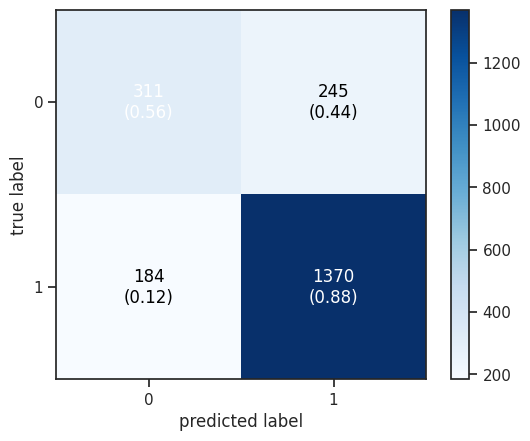

In [48]:
cm1 = confusion_matrix(y_test, y_pred, labels=model1.classes_)
fig, ax = plot_confusion_matrix(conf_mat=cm1,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Here We cannot see much good confusion matrix, We need to fine tune the model.

In [49]:
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model1, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: 0.802000 using {'learning_rate': 0.1, 'n_estimators': 500}
0.734215 (0.000428) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.734215 (0.000428) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.734215 (0.000428) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.734215 (0.000428) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.734215 (0.000428) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.734215 (0.000428) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.734215 (0.000428) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.734215 (0.000428) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.734215 (0.000428) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.734215 (0.000428) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.734215 (0.000428) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.784697 (0.009542) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.734215 (0.000428) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.785550

In [50]:
# Create adaboost classifer object
abclass = AdaBoostClassifier(n_estimators=500, learning_rate=0.1, random_state=0)

# Train Adaboost Classifer
modelclass = abc.fit(X_train, y_train.values.ravel())

#Predict the response for test dataset
y_pred = modelclass.predict(X_test)

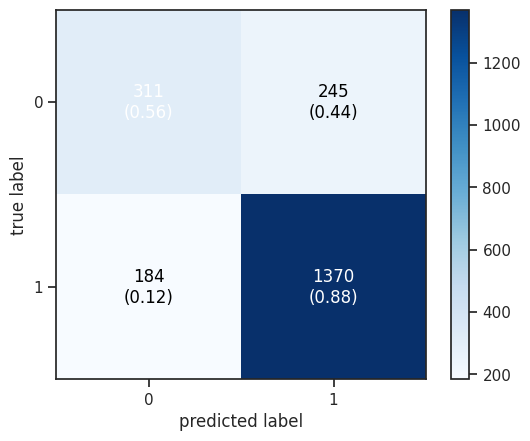

In [51]:
cm1 = confusion_matrix(y_test, y_pred, labels=modelclass.classes_)
fig, ax = plot_confusion_matrix(conf_mat=cm1,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

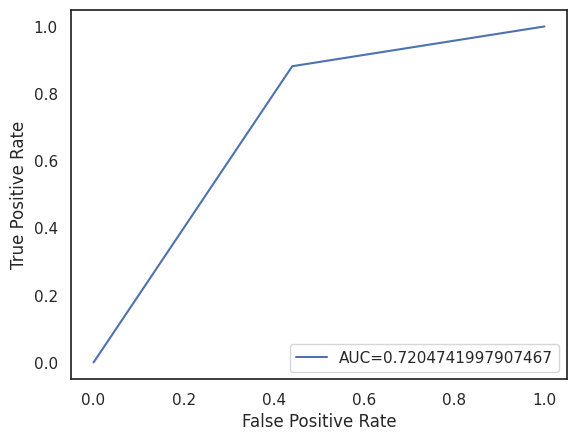

In [52]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

ON fine tunining also we cannot see any improvement in confusion matix, Lets balance this class using SMOTE techniques.

## Applying SMOTEN

In [53]:
# Here due to Imbalance class we do not have a proper accuracy we need to balnce this.

In [54]:
sm = SMOTEN(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print(y.value_counts())
print(y_res.value_counts())

Churn_cat
1.0          5163
0.0          1869
dtype: int64
Churn_cat
0.0          5163
1.0          5163
dtype: int64


In [55]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [56]:
abc1 = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=42)

# Train Adaboost Classifer
model2 = abc1.fit(X_train_res, y_train_res.values.ravel())


#Predict the response for test dataset
y_pred_res = model2.predict(X_test_res)

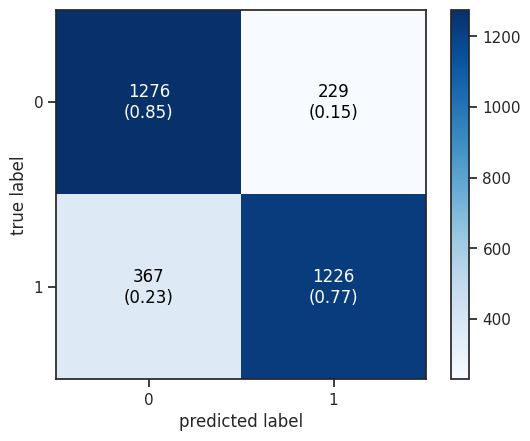

In [57]:
cm = confusion_matrix(y_test_res, y_pred_res, labels=modelclass.classes_)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [58]:
print("AdaBoost Classifier Model Accuracy:", accuracy_score(y_test_res, y_pred_res))

AdaBoost Classifier Model Accuracy: 0.8076178179470627


In [59]:
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model2, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: 0.802000 using {'learning_rate': 0.1, 'n_estimators': 500}
0.734215 (0.000428) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.734215 (0.000428) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.734215 (0.000428) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.734215 (0.000428) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.734215 (0.000428) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.734215 (0.000428) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.734215 (0.000428) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.734215 (0.000428) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.734215 (0.000428) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.734215 (0.000428) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.734215 (0.000428) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.784697 (0.009542) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.734215 (0.000428) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.785550

In [60]:
y_pred_proba = model2.predict_proba(X_test_res)[::,1]

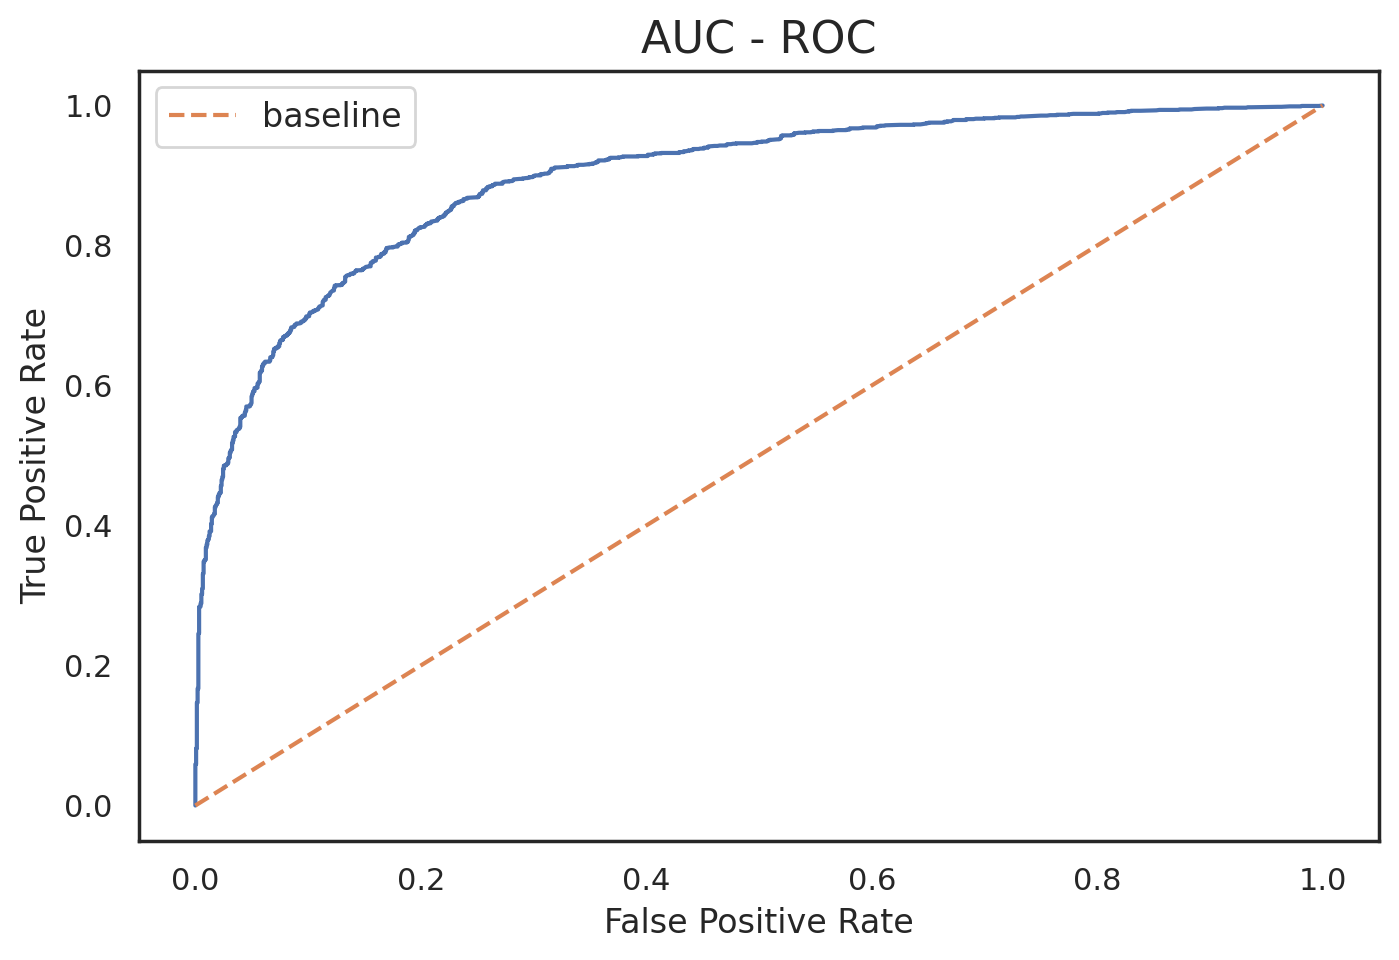

In [62]:
fpr, tpr, _ = roc_curve(y_test_res,  y_pred_proba)
fig, ax = plt.subplots(figsize=(8,5), dpi = 200)
ax.plot(fpr, tpr)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--') 

plt.title('AUC - ROC', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(fontsize=12);

Here we can see great improvement in our our Normalized score for the both classes are 85% and 77%